In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class BooksDataset:
    def __init__(self, users, ratings, books):
        self.users = users
        self.ratings = ratings
        self.books = books


    def __len__(self):
        return len(self.users)


    def __getitem__(self, idx):
        return {
            'users': torch.tensor(self.users[idx], dtype=torch.long),
            'ratings': torch.tensor(self.ratings[idx], dtype=torch.float32),
            'books': torch.tensor(self.books[idx], dtype=torch.long)
        }

In [4]:
class BookRecommender(nn.Module):
    def __init__(self, n_books, n_users):
        super().__init__()
        
        self.user_embed = nn.Embedding(n_users, 32)
        self.book_embed = nn.Embedding(n_books, 32)
        self.out = nn.Linear(64, 1)


    def forward(self, users, books):
        user_embed = self.user_embed(users)
        book_embed = self.book_embed(books)
        output = torch.cat([user_embed, book_embed], dim=1) 
        output = self.out(output)

        return output

In [5]:
ratings_df = pd.read_csv('main_dataset/updated_ratings.csv')
ratings_df

,user_id,isbn,rating
0,276727,0446520802,0.0
1,276746,0425115801,0.0
2,276746,0449006522,0.0
3,276746,0553561618,0.0
4,276746,055356451X,0.0
...,...,...,...
467095,276704,0441007813,0.0
467096,276704,0446353957,0.0
467097,276704,0446605409,0.0
467098,276709,0515107662,5.0


In [6]:
# Correct each unique user_id and isbn to 0 based indexes for the NN to process properly as they are strings

lbl_userid = preprocessing.LabelEncoder()
lbl_isbn = preprocessing.LabelEncoder()
ratings_df["user_id"] = lbl_userid.fit_transform(ratings_df["user_id"].values)
ratings_df["isbn"] = lbl_isbn.fit_transform(ratings_df["isbn"].values)

ratings_df = ratings_df[ratings_df["rating"] != 0]
ratings_df

,user_id,isbn,rating
6,53992,40226,4.0
7,53993,43448,3.0
8,53994,40924,4.0
9,53995,28356,2.5
11,53996,17298,2.5
...,...,...,...
467083,53985,51274,5.0
467084,53985,52819,3.0
467094,53987,10758,3.0
467098,53988,31174,5.0


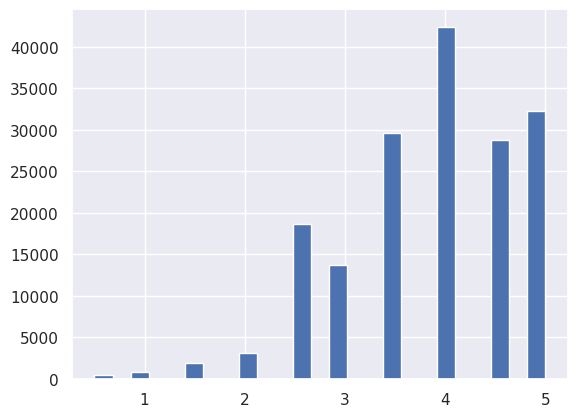

In [7]:
plt.hist(ratings_df["rating"], 25)
plt.show()

In [38]:
train, test = model_selection.train_test_split(
    ratings_df, test_size=0.2, random_state=42, stratify=ratings_df["rating"].values
    )

In [39]:
train_ds = BooksDataset(
    users=train["user_id"].values,
    books=train["isbn"].values,
    ratings=train["rating"].values
    )

test_ds = BooksDataset(
    users=test["user_id"].values,
    books=test["isbn"].values,
    ratings=test["rating"].values
    )

In [40]:
train_dl = DataLoader(train_ds, batch_size=50, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=50, shuffle=True, num_workers=2)

In [33]:
%%html
<span style="font-size: 40px;">Train on the ratings_df</span>

In [47]:
max_user_index = max(train["user_id"].max(), test["user_id"].max())
max_book_index = max(train["isbn"].max(), test["isbn"].max())
print("Max User Index:", max_user_index)
print("Max Book Index:", max_book_index)

plot_steps, print_steps = 1000, 1000
step_count = 0

epochs = 3
num_folds = 5
lr = 0.001
gamma = 0.999
sch_step_size = 1

model = BookRecommender(max_book_index + 1, max_user_index + 1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sch = torch.optim.lr_scheduler.StepLR(optimizer, sch_step_size, gamma=gamma)
loss_function = nn.MSELoss()
kf = model_selection.KFold(n_splits=num_folds, shuffle=True)

Max User Index: 54425
Max Book Index: 58475


In [48]:
all_losses = []
model.train()
total_loss = 0
for epoch in range(epochs):
    for i, batch in enumerate(train_dl):
        users = batch['users']
        books = batch['books']
        ratings = batch['ratings'].view(-1, 1) # Labels vector

        # Forward pass
        optimizer.zero_grad()
        outputs = model(users, books) # Predictions vector

        # Calculate the loss based on Predictions and Labels
        loss = loss_function(outputs, ratings)
        total_loss += loss.sum().item()

        # Backpropagate the loss
        loss.backward()
        optimizer.step()

        """Done with the batch training"""

        # Stats
        step_count += len(users)
        if step_count % plot_steps == 0:
            avg_loss = total_loss*1000/(plot_steps*len(users))
            print(f"Epoch: {epoch + 1}, Step: {step_count}, Avg. Loss: {avg_loss}")
            all_losses.append(avg_loss)
            total_loss = 0

    sch.step()

torch.save(model.state_dict(), "./models/model_no_cross_val.pth")

Epoch: 1, Step: 1000, Avg. Loss: 6.2747367477416995
Epoch: 1, Step: 2000, Avg. Loss: 6.30733850479126
Epoch: 1, Step: 3000, Avg. Loss: 6.173913059234619
Epoch: 1, Step: 4000, Avg. Loss: 6.129496536254883
Epoch: 1, Step: 5000, Avg. Loss: 6.192180480957031
Epoch: 1, Step: 6000, Avg. Loss: 6.102102794647217
Epoch: 1, Step: 7000, Avg. Loss: 5.827107696533203
Epoch: 1, Step: 8000, Avg. Loss: 5.63977159500122
Epoch: 1, Step: 9000, Avg. Loss: 5.5898040008544925
Epoch: 1, Step: 10000, Avg. Loss: 5.566840686798096
Epoch: 1, Step: 11000, Avg. Loss: 5.444704933166504
Epoch: 1, Step: 12000, Avg. Loss: 5.679953708648681
Epoch: 1, Step: 13000, Avg. Loss: 5.464562683105469
Epoch: 1, Step: 14000, Avg. Loss: 5.312072715759277
Epoch: 1, Step: 15000, Avg. Loss: 5.253872127532959
Epoch: 1, Step: 16000, Avg. Loss: 5.37557466506958
Epoch: 1, Step: 17000, Avg. Loss: 5.1121275520324705
Epoch: 1, Step: 18000, Avg. Loss: 5.126317653656006
Epoch: 1, Step: 19000, Avg. Loss: 5.057392635345459
Epoch: 1, Step: 20000

In [50]:
fold_losses = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_ds)):
    print(f"Fold {fold + 1}")
    
    train_fold = torch.utils.data.Subset(train_ds, train_idx)
    val_fold = torch.utils.data.Subset(train_ds, val_idx)

    train_dl = DataLoader(train_fold, batch_size=64, shuffle=True)
    val_dl = DataLoader(val_fold, batch_size=64, shuffle=False)

    fold_loss = []
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for i, batch in enumerate(train_dl):
            users = batch['users']
            books = batch['books']
            ratings = batch['ratings'].view(-1, 1).to(torch.float32)

            optimizer.zero_grad()
            outputs = model(users, books)

            loss = loss_function(outputs, ratings)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Update learning rate scheduler
        sch.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dl:
                users = batch['users']
                books = batch['books']
                ratings = batch['ratings'].view(-1, 1)

                outputs = model(users, books)
                val_loss += loss_function(outputs, ratings).item()

        fold_loss.append(val_loss / len(val_dl))
        print(f"Epoch: {epoch}, Validation Loss: {val_loss / len(val_dl)}")

    fold_losses.append(fold_loss)

# Compute average validation loss across all folds
avg_losses = np.mean(fold_losses, axis=0)
print("Average Validation Losses:", avg_losses)
torch.save(model.state_dict(), "./models/model_cross_val.pth")

Fold 1
Epoch: 0, Validation Loss: 0.6186666551024415
Epoch: 1, Validation Loss: 0.6108519741269045
Epoch: 2, Validation Loss: 0.6131078596031942
Fold 2
Epoch: 0, Validation Loss: 0.47278935923132787
Epoch: 1, Validation Loss: 0.48840106756881224
Epoch: 2, Validation Loss: 0.5070624304025673
Fold 3
Epoch: 0, Validation Loss: 0.38014011053844937
Epoch: 1, Validation Loss: 0.40388167975253836
Epoch: 2, Validation Loss: 0.42654703290656554
Fold 4
Epoch: 0, Validation Loss: 0.33008094322542814
Epoch: 1, Validation Loss: 0.35920774136171785
Epoch: 2, Validation Loss: 0.38712086927059086
Fold 5
Epoch: 0, Validation Loss: 0.3045049917559291
Epoch: 1, Validation Loss: 0.33516112981840623
Epoch: 2, Validation Loss: 0.3631516067094581
Average Validation Losses: [0.42123641 0.43950072 0.45939796]


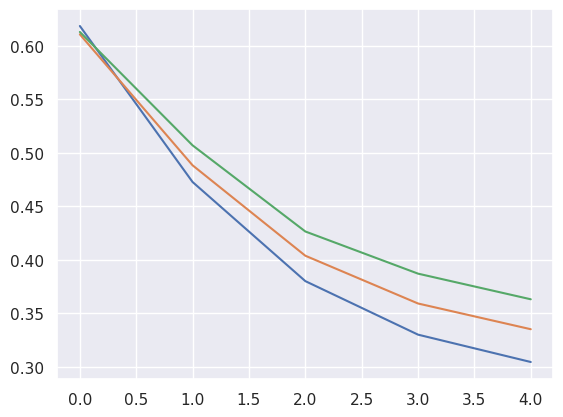

In [51]:
plt.figure()
plt.plot(fold_losses)
plt.show()

In [59]:
from sklearn.metrics import mean_squared_error

model_outputs = []
target_ratings = []

model.eval()
with torch.no_grad():
    for batch in test_dl:
        users = batch['users']
        books = batch['books']
        ratings = batch['ratings'].view(-1, 1)

        output = model(users, books)
        model_outputs.append(output.sum().item() / len(users))
        target_ratings.append(ratings.sum().item() / len(users))
        
        print(f"Model Error: {abs(output - ratings)}\n\n")

rmse = mean_squared_error(target_ratings, model_outputs, squared=False)
print(f"rmse: {rmse}")

Model Error: tensor([[0.2260],
        [0.0857],
        [0.0966],
        [0.5324],
        [1.4830],
        [0.2109],
        [0.0094],
        [0.3108],
        [0.5536],
        [1.2470],
        [0.4543],
        [0.2146],
        [0.6503],
        [0.1746],
        [0.1682],
        [0.5690],
        [0.0726],
        [0.4604],
        [0.9034],
        [0.1014],
        [1.2429],
        [1.8561],
        [0.7890],
        [1.0043],
        [1.5101],
        [1.2358],
        [1.1760],
        [0.5469],
        [2.1095],
        [0.3623],
        [0.1772],
        [0.5658],
        [0.4913],
        [0.2974],
        [0.4419],
        [0.2114],
        [0.0209],
        [0.2355],
        [0.1297],
        [0.0861],
        [1.4510],
        [0.6623],
        [1.1650],
        [1.1530],
        [0.4198],
        [0.8074],
        [0.3529],
        [0.3127],
        [1.2248],
        [0.2643]])


Model Error: tensor([[0.6971],
        [1.0970],
        [0.3112],
        [1.3037],